In [1]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *
HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol, allen_mouse_genes = LoadGeneINFO()

## Edge Overlap

In [6]:
import rdata

In [8]:
#result = pyreadr.read_r('dat/Jon_data/maintain_region-by_local_global.Rdata')
parsed = rdata.parser.parse_file('dat/Jon_data/maintain_region-by_local_global.Rdata')

In [9]:
converted = rdata.conversion.convert(parsed)

In [12]:
print(converted.keys())

dict_keys(['con', 'res'])


In [32]:
def convertRdat2DF(Rdata):
    data = Rdata.data
    index = Rdata['dim_0'].data
    columns = Rdata['dim_1'].data
    adj_mat = pd.DataFrame(data=data, index=index, columns=columns)
    return adj_mat 

Jon_permut_adj_mats = []
for xx in converted["con"]:
    #print(dir(xx))
    #print(xx['dim_0'].data)
    adjmat_tmp = convertRdat2DF(xx)
    Jon_permut_adj_mats.append(adjmat_tmp)

In [35]:
g = LoadConnectome2()

In [76]:
def GetGraphEdges(g):
    es = g.es
    vs = g.vs
    edges_w_name = []
    for e in es:
        edges_w_name.append("{}-{}".format(vs[e.source]["label"], vs[e.target]["label"]))
    return set(edges_w_name)

In [77]:
Real_graph_edges = GetGraphEdges(g)

In [84]:
Jon_Edge_Overlap = []
for xx in converted["con"]:
    adjmat_tmp = convertRdat2DF(xx)
    #on_permut_adj_mats.append(adjmat_tmp)
    g_tmp = LoadConnectome2(adjmat_tmp)
    edges_tmp = GetGraphEdges(g_tmp)
    Jon_Edge_Overlap.append(len(Real_graph_edges.intersection(edges_tmp)))
Jon_Edge_Overlap = Jon_Edge_Overlap[1:]

In [89]:
JW_Edge_Overlap = []
for i in range(1, 1001, 1):
    adj_mat_perm = pd.read_csv("dat/permut_connectome_oct07/{}.csv".format(i), index_col=0)
    g_perm = LoadConnectome2(adj_mat_perm)
    edges_tmp = GetGraphEdges(g_perm)
    JW_Edge_Overlap.append(len(Real_graph_edges.intersection(edges_tmp)))

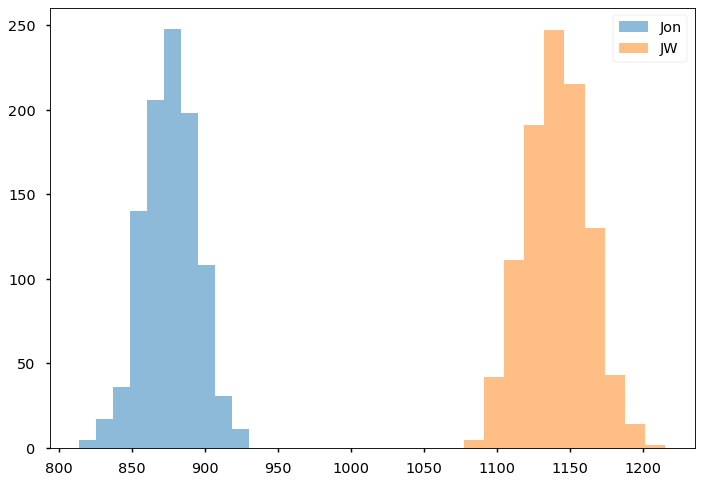

In [93]:
plt.hist(Jon_Edge_Overlap, alpha=0.5, label="Jon")
plt.hist(JW_Edge_Overlap, alpha=0.5, label="JW")
plt.legend()
plt.show()

In [99]:
Jon_Edge_Overlap = []
for i, xx in enumerate(converted["con"]):
    if i == 0:
        continue
    if i == 1:
        adjmat_tmp = convertRdat2DF(xx)
        Real_graph_edges = GetGraphEdges(LoadConnectome2(adjmat_tmp))
    else:
        adjmat_tmp = convertRdat2DF(xx)
        g_tmp = LoadConnectome2(adjmat_tmp)
        edges_tmp = GetGraphEdges(g_tmp)
        Jon_Edge_Overlap.append(len(Real_graph_edges.intersection(edges_tmp)))

In [100]:
JW_Edge_Overlap = []
adj_mat_perm = pd.read_csv("dat/permut_connectome_oct07/1.csv".format(i), index_col=0)
g_perm = LoadConnectome2(adj_mat_perm)
Real_graph_edges = GetGraphEdges(g_perm)
for i in range(2, 1002, 1):
    adj_mat_perm = pd.read_csv("dat/permut_connectome_oct07/{}.csv".format(i), index_col=0)
    g_perm = LoadConnectome2(adj_mat_perm)
    edges_tmp = GetGraphEdges(g_perm)
    JW_Edge_Overlap.append(len(Real_graph_edges.intersection(edges_tmp)))

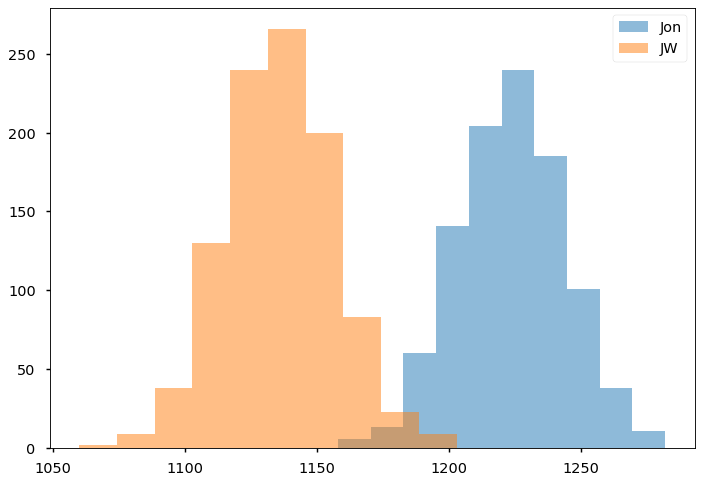

In [101]:
plt.hist(Jon_Edge_Overlap, alpha=0.5, label="Jon")
plt.hist(JW_Edge_Overlap, alpha=0.5, label="JW")
plt.legend()
plt.show()

In [36]:
def CohesivenessProfile(BiasDF, Jon_permut_adj_mats, g=g, EdgeWeightsDict={}):
    EdgeWeightsDict = {}
    topNs = list(range(200, 10, -5))
    ASD_Conn_Z, ASD_Cohe_Z, ASD_Conn_P, ASD_Cohe_P, ASD_Conn_E, ASD_Cohe_E = [],[],[],[],[],[]
    for topN in topNs:
        Permuted_ASD_cohe = []
        Permuted_ASD_conn = []
        Permuted_Sib_cohe = []
        Permuted_Sib_conn = []
        for i in range(1000):
            adj_mat_perm = Jon_permut_adj_mats[i]
            g_perm = LoadConnectome2(adj_mat_perm)
            asd_cohe, asd_conn = ScoreSTRSet(g_perm, BiasDF.head(topN).index.values, EdgeWeightsDict)
            Permuted_ASD_cohe.append(asd_cohe)
            Permuted_ASD_conn.append(asd_conn)
        asd_cohe, asd_conn = ScoreSTRSet(g, BiasDF.head(topN).index.values, EdgeWeightsDict)

        asd_z_conn, asd_p_conn = GetPermutationP(Permuted_ASD_conn, asd_conn)
        asd_z_cohe, asd_p_cohe = GetPermutationP(Permuted_ASD_cohe, asd_cohe)
        effect_conn = asd_conn/np.mean(Permuted_ASD_conn)
        effect_cohe = asd_cohe/np.mean(Permuted_ASD_cohe)
        ASD_Conn_Z.append(asd_z_conn); ASD_Cohe_Z.append(asd_z_cohe)
        ASD_Conn_P.append(asd_p_conn); ASD_Cohe_P.append(asd_p_cohe)
        ASD_Conn_E.append(effect_conn); ASD_Cohe_E.append(effect_cohe)
    return ASD_Cohe_E, ASD_Cohe_P
topNs = list(range(200, 10, -5))
def addline(TopNs, Eff, ax, color="grey", ls="dashed"):
    ax.plot(TopNs, Eff, color=color, ls="solid", lw=3)

In [39]:
ASD_EW_Spec = pd.read_csv("dat/bias2/ASD.EW.Spec.bias.csv", index_col="STR")

In [42]:
EWE, EWP = CohesivenessProfile(ASD_EW_Spec, Jon_permut_adj_mats)
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax = plt.subplots(dpi=720, figsize=(16,8))
plt.style.use('seaborn-talk')
matplotlib.rcParams.update({'font.size': 32})

addline(topNs, EWE, ax, "blue")

ax.hlines(xmin=min(topNs), xmax=max(topNs), y=1, ls="--", color="grey")
ax.grid(True)

ax.set_ylabel("Cohesiveness Effect Size",fontsize=28)
ax.set_xlabel("Number of Most Biased Structures",fontsize=28)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

plt.tight_layout()
plt.show()

In [44]:
Jon_60 = pd.read_csv("dat/jon_data/exprank-asd.csv", index_col="STR")
EWE, EWP = CohesivenessProfile(Jon_60, Jon_permut_adj_mats)
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax = plt.subplots(dpi=720, figsize=(16,8))
plt.style.use('seaborn-talk')
matplotlib.rcParams.update({'font.size': 32})

addline(topNs, EWE, ax, "blue")

ax.hlines(xmin=min(topNs), xmax=max(topNs), y=1, ls="--", color="grey")
ax.grid(True)

ax.set_ylabel("Cohesiveness Effect Size",fontsize=28)
ax.set_xlabel("Number of Most Biased Structures",fontsize=28)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

plt.tight_layout()
plt.show()

In [65]:
def BiasCorrelation(DF1, DF2):
    Bias1, Bias2 = [], []
    Rank1, Rank2 = [], []
    for STR in DF1.index.values:
        bias1 = DF1.loc[STR, "EFFECT"]
        bias2 = DF2.loc[STR, "EFFECT"]
        rank1 = DF1.loc[STR, "Rank"]
        rank2 = DF2.loc[STR, "Rank"]
        Bias1.append(bias1); Bias2.append(bias2)
        Rank1.append(rank1); Rank2.append(rank2)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3), dpi=120)
    ax1.scatter(Bias1, Bias2, s=3)
    ax1.set_xlabel("Bias1")
    ax1.set_ylabel("Bias2")
    print(pearsonr(Bias1, Bias2))
    ax2.scatter(Rank1, Rank2, s=3)
    ax2.set_xlabel("Rank1")
    ax2.set_ylabel("Rank2")
    print(pearsonr(Rank1, Rank2))
    plt.show()

In [59]:
BiasSpec = pd.read_csv("dat/bias2/ASD.EW.Spec.bias.csv", index_col="STR")
#BiasSpec2 = pd.read_csv("dat/jon_data/exprank-asd.csv", index_col="STR")
BiasSpec2 = pd.read_csv("dat/bias2/ASD.EW.pLI.Spec.bias.csv", index_col="STR")

In [60]:
BiasCorrelation(BiasSpec, BiasSpec2)

(0.9984440217723899, 1.657027854141709e-266)
(0.9972804557906422, 5.971959253669601e-241)


In [61]:
SetA = set(BiasSpec.head(50).index)
SetB = set(BiasSpec2.head(50).index)
print(SetA.difference(SetB))
print(SetB.difference(SetA))

{'Subiculum_dorsal_part', 'Frontal_pole_cerebral_cortex'}
{'Central_amygdalar_nucleus', 'Lateral_visual_area'}


In [63]:
BiasSpec = pd.read_csv("dat/bias2/ASD.Meta.Spec.bias.csv", index_col="STR")
BiasSpec2 = pd.read_csv("dat/bias2/ASD.EW.Spec.bias.csv", index_col="STR")

(0.9864565197516938, 1.230369542724153e-167)
(0.9869424623920563, 2.672095362665305e-169)


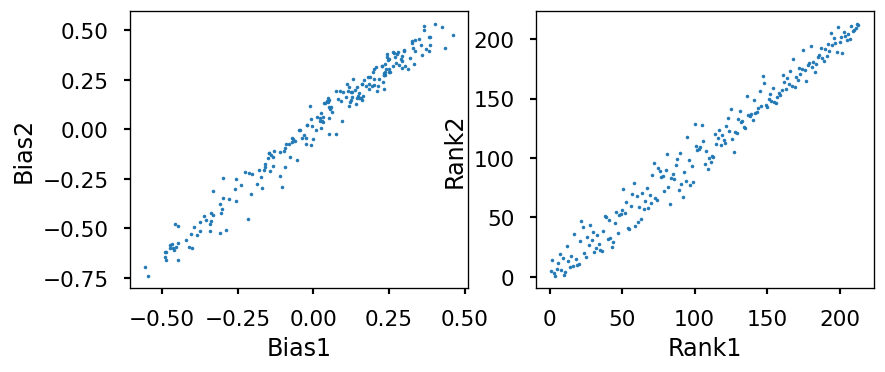

In [67]:
BiasCorrelation(BiasSpec, BiasSpec2)

In [68]:
SetA = set(BiasSpec.head(50).index)
SetB = set(BiasSpec2.head(50).index)
print(SetA.difference(SetB))
print(SetB.difference(SetA))

{'Lateral_visual_area', 'Anterior_cingulate_area_ventral_part', 'posteromedial_visual_area', 'Posterior_parietal_association_areas', 'Central_amygdalar_nucleus'}
{'Subparafascicular_nucleus_magnocellular_part', 'Piriform_area', 'Parataenial_nucleus', 'Lateral_septal_nucleus_caudal_caudodorsal_part', 'Rhomboid_nucleus'}


In [4]:
Jon_Sib_Bias = pd.read_csv("dat/Jon_data/sibling-exp_rank.csv")
Jon_Sib_Bias.columns = ["STR", "EFFECT", "Rank", "NGene"]
Jon_Sib_Bias = Jon_Sib_Bias.set_index("STR")

JW_Sib_Bias = pd.read_csv("dat/bias2/ASD.Siblings.spec.bias.csv", index_col="STR")

(array([ 2.,  6., 22., 46., 46., 33., 23., 15., 17.,  3.]),
 array([-0.12981807, -0.10303785, -0.07625762, -0.0494774 , -0.02269717,
         0.00408306,  0.03086328,  0.05764351,  0.08442373,  0.11120396,
         0.13798419]),
 <BarContainer object of 10 artists>)

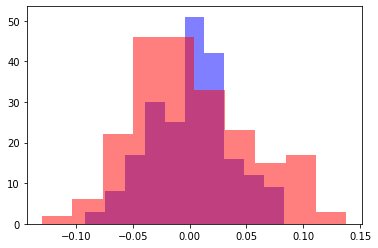

In [6]:
plt.hist(JW_Sib_Bias["EFFECT"].values, color="blue", alpha=0.5)
plt.hist(Jon_Sib_Bias["EFFECT"].values, color="red", alpha=0.5)

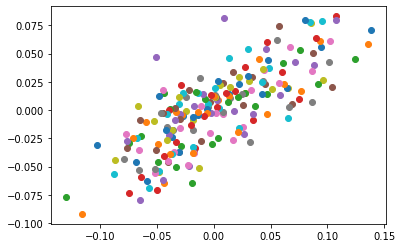

In [7]:
for STR in Jon_Sib_Bias.index:
    plt.scatter(Jon_Sib_Bias.loc[STR, "EFFECT"], JW_Sib_Bias.loc[STR, "EFFECT"])

In [8]:
Jon_sib_weights = pd.read_csv("dat/Jon_data/sibling-gene_weight.csv")

In [9]:
Jon_sib_weights

,gen,weight
0,100,1
1,10003,1
2,1001,1
3,100113407,1
4,100129543,1
...,...,...
1346,9923,1
1347,9935,1
1348,9945,1
1349,9968,1


In [13]:
def CountMut(DF):
    N_LGD, N_mis, N_Dmis, N_syn = 0,0,0,0
    for i, row in DF.iterrows():
        GeneEff = row["GeneEff"].split(";")[0]
        if GeneEff in ["frameshift", "splice_acceptor", "splice_donor", "start_lost", "stop_gained", "stop_lost"]:
            N_LGD += 1
        elif GeneEff == "missense":
            N_mis += 1
            row["REVEL"] = row["REVEL"].split(";")[0]
            if row["REVEL"] != ".":
                if float(row["REVEL"]) > 0.5:
                    N_Dmis += 1
        elif GeneEff == "synonymous":
            N_syn += 1
    return N_LGD, N_mis, N_Dmis, N_syn

def Mut2GeneDF(MutDF, w_LGD, w_Dmis):
    genes = np.array(list(set(MutDF["HGNC"].values)))
    dat = []
    gene2MutN = {}
    for g in genes:
        try:
            Entrez = int(GeneSymbol2Entrez[g])
        except:
            Entrez = -1
            continue
        Muts = MutDF[MutDF["HGNC"]==g]
        N_LGD, N_Mis, N_Dmis, N_Syn = CountMut(Muts)
        #gene2MutN[Entrez] = N_LGD * w_LGD + N_Dmis * w_Dmis
        gene2MutN[Entrez] = N_LGD * w_LGD + N_Mis * w_Dmis
    return gene2MutN

In [10]:
ASD_Discov_Muts = pd.read_csv("../dat/genes/SPARK/ASD_Discov_DNVs.txt", delimiter="\t")
ASD_Rep_Muts = pd.read_csv("../dat/genes/SPARK/ASD_Rep_DNVs.txt", delimiter="\t")
ASD_Discov_Trios = pd.read_csv("../dat/genes/SPARK/ASD_Discov_Trios.txt", delimiter="\t")
ASD_Rep_Trios = pd.read_csv("../dat/genes/SPARK/ASD_Rep_Trios.txt", delimiter="\t")
AllMuts = pd.concat([ASD_Discov_Muts, ASD_Rep_Muts])
AllMuts = AllMuts.reset_index()

In [11]:
AllMuts.head(5)

,index,Cohort,FamID,IID,Sex,Pheno,DNASource,VarID,Chrom,Position,...,pExt_HBDR,HGNCv24,DS_AG,DS_AL,DS_DG,DS_DL,DP_AG,DP_AL,DP_DG,DP_DL
0,0,MSSNG,FAM_D4S2Z,D4S2Z-01,Male,Affected,.,10:102239623:C:T,10,102239623,...,1,WNT8B,0.0038,0,0,0,28,-21,28,-43
1,1,MSSNG,FAM_2-1540-003,2-1540-003,Male,Affected,Blood,10:102689078:G:C,10,102689078,...,0.73,SLF2,0,0,0.0001,0,-4,1,34,1
2,2,MSSNG,FAM_1-0337-003,1-0337-003,Male,Affected,White_blood_cell,10:102750651:G:A,10,102750651,...,1,TWNK,0.0032,0,0.0001,0,2,15,2,13
3,3,MSSNG,FAM_F0215,REACH000457,Female,Uncertain,.,10:103436134:C:T,10,103436134,...,1,FBXW4,0,0,0,0.0151,-36,50,26,-36
4,4,MSSNG,FAM_2-1738-001,2-1738-003,Male,Affected,Blood,10:103825375:C:A,10,103825375,...,1,HPS6,0,0,0.0035,0,2,14,9,-45


In [49]:
Sibling_LGD_Mis = pd.read_csv("dat/ASD_Sibling_LGD_Mis.csv")
sib_gene2MutN = Mut2GeneDF(Sibling_LGD_Mis, 1, 1)

In [50]:
Jon_sib_weights = pd.read_csv("dat/Jon_data/sibling-gene_weight.csv")
Jon_sib_gene2MutN = dict(zip(Jon_sib_weights["gen"].values, Jon_sib_weights["weight"].values))

In [51]:
# In Jon not in JW
set(Jon_sib_gene2MutN.keys()).difference(sib_gene2MutN.keys())

{16,
 55,
 833,
 1615,
 2342,
 3376,
 4677,
 6301,
 7407,
 7707,
 8365,
 8969,
 9692,
 10801,
 10941,
 27342,
 55112,
 56105,
 56125,
 57535,
 81553,
 93233,
 116224,
 132243,
 201158,
 441061,
 728434}

In [52]:
set(sib_gene2MutN.keys()).difference(Jon_sib_gene2MutN.keys())

{90113,
 2,
 8195,
 253959,
 8202,
 8204,
 14,
 21,
 57369,
 29,
 253982,
 32,
 286753,
 57380,
 37,
 8242,
 50,
 204851,
 57419,
 442444,
 90187,
 114771,
 344148,
 401494,
 114780,
 114788,
 114791,
 57449,
 114794,
 98,
 57455,
 105,
 254065,
 139378,
 113,
 221301,
 57462,
 57463,
 8312,
 120,
 125,
 344191,
 128,
 57473,
 130,
 57475,
 196740,
 57477,
 57474,
 57479,
 123016,
 57481,
 401546,
 647309,
 57486,
 114836,
 151,
 152,
 57498,
 57497,
 156,
 153,
 160,
 57507,
 163,
 57513,
 57522,
 57523,
 57528,
 57533,
 57538,
 57544,
 202,
 147657,
 8394,
 147660,
 8395,
 57549,
 114897,
 8406,
 217,
 221400,
 123099,
 220,
 221,
 224,
 221409,
 57567,
 57572,
 8425,
 57579,
 8428,
 238,
 239,
 221424,
 240,
 57589,
 246,
 57592,
 57594,
 8443,
 57596,
 8445,
 8451,
 57608,
 57609,
 90378,
 267,
 90379,
 268,
 8462,
 275,
 57615,
 57621,
 729359,
 57624,
 8473,
 147741,
 57623,
 8480,
 290,
 57634,
 221476,
 293,
 8483,
 57639,
 221481,
 8490,
 139562,
 57643,
 131375,
 114990,
 850

In [65]:
gene = Entrez2Symbol[10880]
print(gene)
AllMuts[AllMuts["HGNC"]==gene][["FamID","IID","Sex","Pheno", "HGNC", "REVEL", "GeneEff"]]

ACTL7B


,FamID,IID,Sex,Pheno,HGNC,REVEL,GeneEff
9032,216-4322,05C48774,Male,Affected,ACTL7B,.,synonymous
13670,12837,12837.p1,Male,Affected,ACTL7B,.,synonymous
13671,12722,12722.s1,Male,Unaffected,ACTL7B,.,start_lost


In [77]:
g = LoadConnectome2() # Load Connectiome
EdgeWeightsDict = EdgeDict(g, keyon="label")

meta_new = pd.read_csv("dat/bias2/ASD.Meta.Spec.bias.csv") # Load Bias
meta_new = meta_new.set_index("STR")
meta_new.head(2)

,EFFECT,REGION,Rank
STR,,,
Dentate_gyrus,0.459557,Hippocampal_region,1
Field_CA1,0.434854,Hippocampal_region,2


In [78]:
adj_mat = pd.read_csv(ConnFil, index_col=0)
adj_mat_local, adj_mat_distal = LocalDistal_Region()
g_local_region = LoadConnectome2(ConnFil=adj_mat_local)
g_distal_region = LoadConnectome2(ConnFil=adj_mat_distal)
EdgeWeightsDict_local_region = EdgeDict(g_local_region, keyon="label")
EdgeWeightsDict_distal_region = EdgeDict(g_distal_region, keyon="label")

In [79]:
# ASD
CandidateSTRs = meta_new.head(50).index.values
asd_scores = ScoreSTRSet(g, CandidateSTRs, EdgeWeightsDict)
print("Total   % .3f"% np.mean(asd_scores))
asd_scores = ScoreSTRSet(g_local_region, CandidateSTRs, EdgeWeightsDict_local_region)
print("Local   % .3f"% np.mean(asd_scores))
asd_scores = ScoreSTRSet(g_distal_region, CandidateSTRs, EdgeWeightsDict_distal_region)
print("Distal  % .3f"% np.mean(asd_scores))

Total    0.367
Local    0.535
Distal   0.294


In [87]:
SA_wd = "/Users/jiayao/Work/ASD_Circuits/src/dat/circuits2/ASD_Pad1_SA.csv"
Weighted = False; Direction = False
InCirtuitNodes = GetBestCoheSAFil(SA_wd, Weighted, Direction, g=g, EdgeWeightsDict=EdgeWeightsDict)
asd_scores_total = ScoreSTRSet(g, InCirtuitNodes, EdgeWeightsDict, Weighted=Weighted, Direction=Direction)
asd_scores_local = ScoreSTRSet(g_local_region, InCirtuitNodes, EdgeWeightsDict_local_region, Weighted=Weighted, Direction=Direction)
asd_scores_distal = ScoreSTRSet(g_distal_region, InCirtuitNodes, EdgeWeightsDict_distal_region, Weighted=Weighted, Direction=Direction)
print("Total     % .3f"% np.mean(asd_scores_total))
print("Local     % .3f"% np.mean(asd_scores_local))
print("Distal    % .3f"% np.mean(asd_scores_distal))

Total      0.382
Local      0.432
Distal     0.310


In [88]:
print(len(InCirtuitNodes))

35


In [89]:
InCirtuitNodes

array(['Orbital_area_lateral_part', 'Prelimbic_area',
       'Orbital_area_ventrolateral_part', 'Dorsal_peduncular_area',
       'Infralimbic_area', 'Nucleus_accumbens',
       'Anterior_olfactory_nucleus', 'Accessory_olfactory_bulb',
       'Lateral_posterior_nucleus_of_the_thalamus',
       'Endopiriform_nucleus_dorsal_part', 'Claustrum',
       'Primary_visual_area', 'Subiculum_dorsal_part',
       'Agranular_insular_area_ventral_part', 'Anteromedial_visual_area',
       'Primary_somatosensory_area_lower_limb', 'Primary_motor_area',
       'Anterior_cingulate_area_dorsal_part', 'Gustatory_areas',
       'Nucleus_of_reuniens', 'Parafascicular_nucleus',
       'Secondary_motor_area',
       'Retrosplenial_area_lateral_agranular_part', 'Caudoputamen',
       'Orbital_area_medial_part', 'Frontal_pole_cerebral_cortex',
       'Visceral_area', 'Basolateral_amygdalar_nucleus',
       'Agranular_insular_area_posterior_part',
       'Submedial_nucleus_of_the_thalamus',
       'Anterior_cingu

In [16]:
JW_ExpMat = "../dat/allen-mouse-exp/jon/energy-conn-model-no_log-no_quant_norm.csv"
JW_ExpMat = pd.read_csv(JW_ExpMat, index_col="ROW")
JW_ExpMatNorm = "../dat/allen-mouse-exp/energy-neuronorm.csv"
JW_ExpMatNorm = pd.read_csv(JW_ExpMatNorm, index_col="ROW")

In [32]:
Jon_ExpMat = "../dat/allen-mouse-exp/jon/exp_level-before_norm.csv"
Jon_ExpMat = pd.read_csv(Jon_ExpMat, index_col="ROW")
Jon_ExpMatNorm = "../dat/allen-mouse-exp/jon/exp_level-after_norm.csv"
Jon_ExpMatNorm = pd.read_csv(Jon_ExpMatNorm, index_col="ROW")

In [17]:
JW_ExpMat.head(2)

,Anterior_amygdalar_area,Anterior_cingulate_area_dorsal_part,Anterior_cingulate_area_ventral_part,Nucleus_accumbens,Anterodorsal_nucleus,Anterior_hypothalamic_nucleus,Agranular_insular_area_dorsal_part,Agranular_insular_area_posterior_part,Agranular_insular_area_ventral_part,Nucleus_ambiguus,...,Primary_visual_area,Posterolateral_visual_area,posteromedial_visual_area,Ventral_medial_nucleus_of_the_thalamus,Ventromedial_hypothalamic_nucleus,Ventral_posterolateral_nucleus_of_the_thalamus,Ventral_posteromedial_nucleus_of_the_thalamus,Ventral_posteromedial_nucleus_of_the_thalamus_parvicellular_part,Ventral_tegmental_area,Hypoglossal_nucleus
ROW,,,,,,,,,,,,,,,,,,,,,
1,0.089402,0.060138,0.050112,0.023204,0.034093,0.088305,0.036078,NaN,0.046813,0.032990,...,0.035584,0.179587,0.021418,0.030367,0.115622,0.036984,0.053407,0.033779,0.110354,0.134065
2,0.040017,0.014211,0.023246,0.024009,0.403265,0.025202,0.354581,0.058713,0.145883,0.022381,...,0.043141,0.005781,0.213674,0.052746,0.038968,0.016603,0.018719,0.035381,0.122850,1.065840


In [18]:
dat1 = JW_ExpMat["Anterior_amygdalar_area"].values
dat2 = Jon_ExpMat["Anterior_amygdalar_area"].values
def rm_nan_and_pearsonr(dat1, dat2):
    tmp1, tmp2 = [], []
    for v1, v2 in zip(dat1, dat2):
        if v1 != v1 or v2 != v2:
            continue
        else:
            tmp1.append(v1)
            tmp2.append(v2)
    return pearsonr(tmp1, tmp2)
print(rm_nan_and_pearsonr(dat1, dat2))

(0.911201393837356, 0.0)


In [39]:
dat1 = JW_ExpMatNorm["Anterior_amygdalar_area"].values
dat2 = Jon_ExpMat["Anterior_amygdalar_area"].values
print(rm_nan_and_pearsonr(dat1, dat2))

(0.9692945557075049, 0.0)


In [20]:
# Norm Neuron

In [33]:
cell_comp = pd.read_csv("../dat/cell_composition/Cell_Atlas_for_the_Mouse_brain_2.csv", index_col="Regions")
STRs = cell_comp.index.values
STRs = [modify_str(x) for x in STRs]
cell_comp.index = STRs
STRs = [x.strip() for x in open("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/Structures.txt", 'rt')]
STR_cell_comp = cell_comp[cell_comp.index.isin(STRs)]

In [34]:
# Norm
df = Jon_ExpMat.copy(deep=True)
for c in df.columns.values:
    neuro_count = cell_comp.loc[c, "Neurons [mm-3]"]
    df[c] = (df[c]/neuro_count) * (10**5)

In [35]:
# Log
for c in df.columns.values:
    df[c] = np.log2(1+df[c])

In [36]:
# QUNTILE
df = quantileNormalize(df)

In [37]:
dat1 = df["Anterior_amygdalar_area"].values
dat2 = Jon_ExpMatNorm["Anterior_amygdalar_area"].values
print(rm_nan_and_pearsonr(dat1, dat2))

(0.9674530944770965, 0.0)


In [38]:
STR = "Nucleus_accumbens"
dat1 = df[STR].values
dat2 = Jon_ExpMatNorm[STR].values
print(rm_nan_and_pearsonr(dat1, dat2))

(0.9675096104052767, 0.0)


In [40]:
df_z = []
df = Jon_ExpMat.copy(deep=True)
for i in df.index.values :
    i_z = ZscoreConverting(df.loc[i,:].values)
    df_z.append(i_z)
df_z = pd.DataFrame(data=df_z, columns=df.columns.values, index=df.index.values)

In [41]:
Aggregate = pd.read_csv("../dat/genes/asd/DenovoWEST_TADA.txt", delimiter="\t")
Aggregate['pDenovoWEST'] = pd.to_numeric(Aggregate["pDenovoWEST"], errors='coerce')
Agg_gene2None, Agg_gene2MutN = Aggregate_Gene_Weights(Aggregate, out = "dat/bias2/meta.gene.weights.csv")

In [64]:
Agg_Match = MakeMatchDF(Agg_gene2MutN, N=1000)
ASD_Meta_Spec = AvgSTRZ_Weighted(df_z, Agg_gene2MutN, Match_DF=Agg_Match, Method = 2,
                                              csv_fil = "dat/bias/ASD.Meta.Spec.bias.diff.csv")
RD_Agg_avgZ_RD = RegionDistributions(ASD_Meta_Spec.set_index("STR"), show=True)

Isocortex 	 19 	 Prelimbic_area; Orbital_area_lateral_part; Infralimbic_area; Orbital_area_ventrolateral_part; Primary_visual_area; Anterior_cingulate_area_dorsal_part; Primary_somatosensory_area_lower_limb; Anteromedial_visual_area; Orbital_area_medial_part; Primary_motor_area; Retrosplenial_area_lateral_agranular_part; Visceral_area; Gustatory_areas; Secondary_motor_area; Agranular_insular_area_ventral_part; Anterior_cingulate_area_ventral_part; Posterior_parietal_association_areas; Primary_somatosensory_area_trunk; Lateral_visual_area
Hippocampal_region 	 4 	 Dentate_gyrus; Field_CA1; Field_CA2; Field_CA3
Olfactory_areas 	 3 	 Dorsal_peduncular_area; Anterior_olfactory_nucleus; Accessory_olfactory_bulb
Pallidum 	 1 	 Bed_nuclei_of_the_stria_terminalis
Thalamus 	 5 	 Lateral_posterior_nucleus_of_the_thalamus; Parafascicular_nucleus; Nucleus_of_reuniens; Mediodorsal_nucleus_of_thalamus; Submedial_nucleus_of_the_thalamus
Midbrain 	 1 	 Anterior_pretectal_nucleus
Striatum 	 7 	 Nucleus_

In [65]:
ASD_Meta_Spec = ASD_Meta_Spec.set_index("STR")
meta_jon = pd.read_csv("dat/Jon_data/exp_bias-match-specific.csv")
meta_jon.columns = ["STR", "EFFECT", "Rank", "NGene"]
meta_jon = meta_jon.set_index("STR")
meta_jon.head(2)

,EFFECT,Rank,NGene
STR,,,
Dentate_gyrus,0.511273,1,95
Prelimbic_area,0.463267,2,95


In [66]:
jon50 = set(meta_jon.head(50).index.values)
jw50 = set(ASD_Meta_Spec.head(50).index.values)

In [67]:
ASD_Meta_Spec.head(200)

,EFFECT,REGION,Rank
STR,,,
Dentate_gyrus,0.528232,Hippocampal_region,1
Prelimbic_area,0.464738,Isocortex,2
Field_CA1,0.453302,Hippocampal_region,3
Orbital_area_lateral_part,0.443268,Isocortex,4
Infralimbic_area,0.433055,Isocortex,5
...,...,...,...
Nucleus_prepositus,-0.468327,Medulla,196
Tegmental_reticular_nucleus,-0.477183,Pons,197
Lateral_reticular_nucleus,-0.479135,Medulla,198


In [68]:
print(len(jon50.intersection(jw50)))

49


(0.9985797297698765, 1.099386750125291e-270)

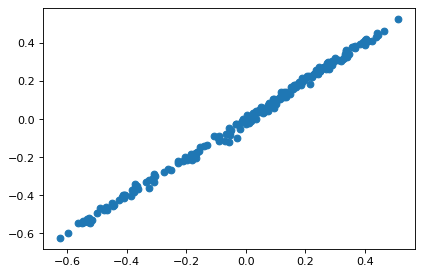

In [69]:
dat1 = []
dat2 = []
for i, row in meta_jon.iterrows():
    dat1.append(row["EFFECT"])
    dat2.append(ASD_Meta_Spec.loc[i, "EFFECT"])
plt.scatter(dat1, dat2)
pearsonr(dat1, dat2)

In [70]:
df_z.to_csv("../dat/allen-mouse-exp/energy-zscore-conn-model.0524.csv")

In [71]:
28 / (15 * 0.75)

2.488888888888889

In [72]:
64 / 60

1.0666666666666667

In [73]:
219 + 1.06 x > 2.5x
219 > (2.5-1.6)

SyntaxError: invalid syntax (<ipython-input-73-d1c2d496e164>, line 1)

In [75]:
219 / (2.5-1.06)

152.08333333333334